<a href="https://colab.research.google.com/github/LinaMariaCastro/curso-ia-para-economia/blob/main/clases/4_Aprendizaje_no_supervisado/3_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inteligencia Artificial con Aplicaciones en Economía I**

- 👩‍🏫 **Profesora:** [Lina María Castro](https://www.linkedin.com/in/lina-maria-castro)  
- 📧 **Email:** [lmcastroco@gmail.com](mailto:lmcastroco@gmail.com)  
- 🎓 **Universidad:** Universidad Externado de Colombia - Facultad de Economía

# 🔽 **Reducción de Dimensionalidad con Análisis de Componentes Principales (PCA)**

**Objetivos de Aprendizaje**

Al finalizar este notebook, serás capaz de:

1.  **Entender la "Maldición de la Dimensionalidad"** y por qué reducir el número de variables es crucial en el análisis económico y de negocios.
2.  **Aplicar el Análisis de Componentes Principales (PCA)** para transformar un conjunto de datos con muchas variables correlacionadas en un conjunto más pequeño de variables no correlacionadas (componentes).
3.  **Interpretar los resultados de PCA** en un contexto de negocio, traduciendo los componentes principales a conceptos económicos tangibles como "índices sintéticos".
4.  **Utilizar PCA como un paso de preprocesamiento** para mejorar el rendimiento de modelos de clustering (K-Means) y de aprendizaje supervisado.

**Introducción**

Imaginemos que somos analistas en el Banco Interamericano de Desarrollo y se nos encarga la tarea de crear un único **"Índice de Salud Macroeconómica"** para todos los países de América Latina. Contamos con una gran cantidad de datos: PIB per cápita, tasa de inflación, tasa de desempleo, balanza comercial, inversión extranjera directa, deuda pública, etc. (más de 50 indicadores).

El problema es evidente: ¿cómo comparamos a Colombia con Argentina si uno tiene baja inflación pero alto desempleo, y el otro tiene casi pleno empleo pero una inflación desbordada? Comparar países a través de 50 dimensiones es computacionalmente complejo y, sobre todo, difícil de interpretar de manera intuitiva. Además, muchas de estas variables están correlacionadas.

La **reducción de dimensionalidad** es la técnica que nos permite resolver este problema. Es como si tomáramos todas esas variables económicas y las "destiláramos" para obtener la esencia. El **Análisis de Componentes Principales (PCA)** es nuestro "alambique".

PCA nos permitirá crear nuevas variables (componentes principales) que son una combinación de las originales. Por ejemplo, podríamos descubrir que:
* **Componente Principal 1 (CP1):** Agrupa fuertemente el PIB, la inversión y el bajo desempleo. Podríamos interpretarlo como un **"Índice de Crecimiento y Prosperidad"**.
* **Componente Principal 2 (CP2):** Agrupa la estabilidad de precios (baja inflación) y una deuda pública controlada. Podríamos llamarlo **"Índice de Estabilidad Macroeconómica"**.

De esta forma, pasamos de 50 variables difíciles de manejar a solo 2 o 3 índices sintéticos que capturan la mayor parte de la información relevante y que sí podemos usar para comparar, visualizar y analizar a los países de manera efectiva.

## Advertencias

- PCA solo se puede utilizar para variables numéricas, ya que se base en el cálculo de la covarianza y la varianza.
- Las variables categóricas se pueden incluir si primero se transforman a números con One-Hot Encoding y Ordinal Encoding.
- Obligatoriamente, las variables se deben estandarizar o ajustar a valores entre cero y uno.

## ¿Cómo funciona PCA?

In [ ]:
from IPython.display import YouTubeVideo

# ID del video: https://www.youtube.com/watch?v=x-7BHjMA15M
YouTubeVideo('x-7BHjMA15M', width=800, height=450)

Antes de saltar a un complejo dataset, entendamos la magia de PCA con un ejemplo de juguete de solo **2 variables**, con datos que generaremos nosotros mismos.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
# 1. Generar Datos Correlacionados
np.random.seed(42) # Para reproducibilidad
# Creamos 100 puntajes de matemáticas (media 70, std dev 10)
puntajes_mat = np.random.normal(70, 10, 100)
# Creamos puntajes de física correlacionados con matemáticas + algo de ruido
puntajes_fis = puntajes_mat * 0.8 + np.random.normal(0, 5, 100) + 10 # El +10 ajusta la media

# Combinamos en una matriz X (100 filas, 2 columnas)
X_simple = np.vstack((puntajes_mat, puntajes_fis)).T

print("Primeros 5 puntajes:")
X_simple[:5,:]

Primeros 5 puntajes:


array([[74.96714153, 62.89685951],
       [68.61735699, 62.79065898],
       [76.47688538, 69.46793572],
       [85.23029856, 74.17285251],
       [67.65846625, 63.32034444]])

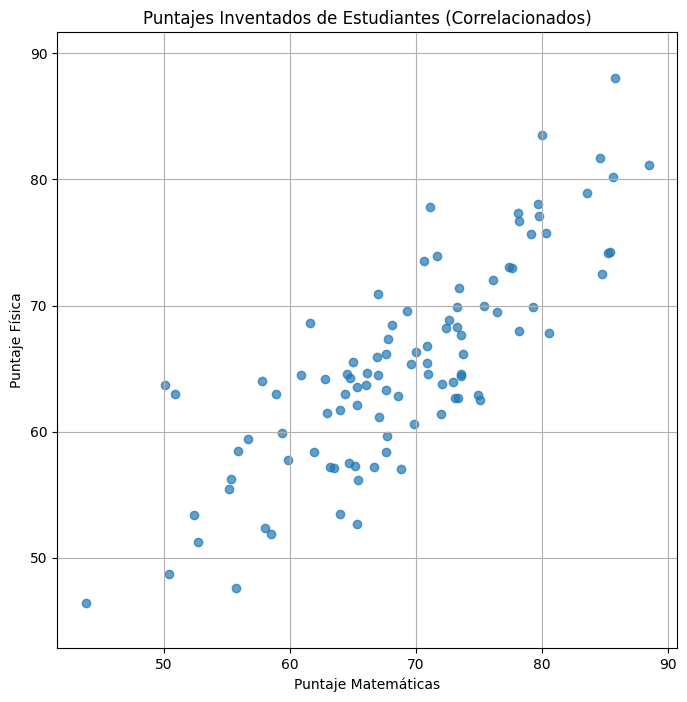

In [3]:
# 2. Graficar los Datos Originales
plt.figure(figsize=(8, 8))
plt.scatter(X_simple[:, 0], X_simple[:, 1], alpha=0.7)
plt.title('Puntajes Inventados de Estudiantes (Correlacionados)')
plt.xlabel('Puntaje Matemáticas')
plt.ylabel('Puntaje Física')
plt.axis('equal') # Asegura que la escala de los ejes sea la misma
plt.grid(True)
plt.show()

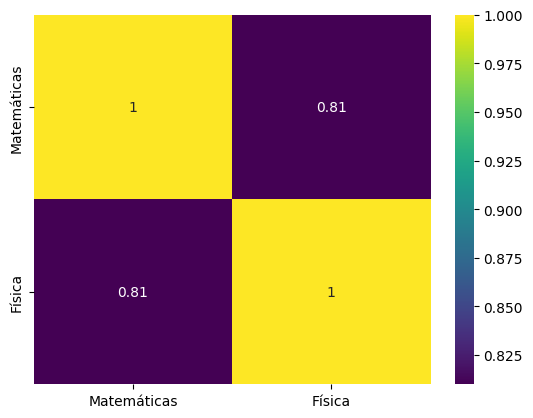

In [4]:
df_simple = pd.DataFrame(X_simple, columns=['Matemáticas', 'Física'])
corr = df_simple.corr().round(2)
sns.heatmap(corr, annot=True, cmap='viridis')
plt.show()

**El Problema:**

Como esperábamos, las variables `Puntaje_Matemáticas` y `Puntaje_Física` están **altamente correlacionadas**. Los estudiantes buenos en una tienden a serlo en la otra. El gráfico muestra una nube de puntos alargada y diagonal. Tenemos dos dimensiones (eje X = Matemáticas, eje Y = Física), pero la información es **redundante**. La mayor parte de la "acción" (la varianza) ocurre a lo largo de esa línea diagonal.

**La Solución de PCA:**

PCA **rotará los ejes** para encontrar una nueva perspectiva que describa mejor los datos. Lo hace encontrando las **direcciones de máxima varianza**.

1.  **Centrar los datos:** PCA funciona sobre datos centrados (media cero). Aunque `StandardScaler` lo hace automáticamente, lo haremos manualmente aquí para entenderlo mejor.
2.  **Aplicar PCA:** Usaremos `sklearn` para encontrar los componentes.
3.  **Visualizar los Componentes:** Graficaremos los vectores de los componentes sobre los datos originales.

In [5]:
# 1. Centrar los datos (restar la media de cada columna)
X_centrado = X_simple - X_simple.mean(axis=0)

In [6]:
# 2. Aplicar PCA
pca_simple = PCA()
pca_simple.fit(X_centrado)

PCA()

In [7]:
# Los componentes son los 'eigenvectors'
print("Dirección de los Componentes Principales (vectores propios):")
print(pca_simple.components_)

Dirección de los Componentes Principales (vectores propios):
[[ 0.75342573  0.65753302]
 [-0.65753302  0.75342573]]


**¿Qué es esto?** Esta matriz te dice la dirección de los nuevos ejes (Componentes Principales) en relación con los ejes originales (Matemáticas y Física). Cada fila representa un componente principal (CP). Los números en la fila indican cómo contribuye cada variable original a ese componente.

**Fila 1 (CP1):** [0.753, 0.657]

- Este es el vector que define la dirección del primer componente principal (CP1), el eje naranja en nuestro gráfico.

- Nos dice que para moverte una unidad a lo largo de este nuevo eje CP1, necesitas moverte 0.753 unidades en la dirección del eje original de Matemáticas Y 0.657 unidades en la dirección del eje original de Física.

- **Interpretación:** Como ambos números son positivos y de magnitud similar, significa que CP1 representa una combinación ponderada de ambas habilidades. Un puntaje alto en CP1 significa ser bueno tanto en Matemáticas como en Física. Por eso lo llamamos "Índice General de Aptitud Científica".

**Fila 2 (CP2):** [-0.657, 0.753]

- Este es el vector que define la dirección del segundo componente principal (CP2), el eje verde, que es perpendicular al CP1.

- Para moverte una unidad a lo largo de CP2, necesitas moverte -0.657 en Matemáticas (hacia la izquierda) y +0.753 en Física (hacia arriba).

- **Interpretación:** Este componente captura la diferencia relativa entre las habilidades. Un puntaje alto en CP2 podría significar ser relativamente mejor en Física que en Matemáticas, y viceversa. Sin embargo, como veremos, este componente es mucho menos importante.

In [8]:
# La varianza explicada por cada uno de los componentes son los 'eigenvalues' (o explained_variance_)
print("\nVarianza explicada por cada componente (valores propios):")
print(pca_simple.explained_variance_)


Varianza explicada por cada componente (valores propios):
[134.90493238  13.64210718]


**¿Qué es esto?** Estos números (los eigenvalues o valores propios) te dicen cuánta varianza (información, dispersión) de los datos originales es capturada por cada componente principal. Son la "longitud" efectiva de los nuevos ejes en términos de información.

**CP1:** 134.9

- El primer componente captura una gran cantidad de la dispersión total de los puntos.

**CP2:** 13.6

- El segundo componente captura mucha menos dispersión.

- **Interpretación:** La diferencia enorme entre estos dos valores confirma lo que vimos en el gráfico: la mayor parte de la "acción" (la variabilidad de los puntajes) ocurre a lo largo de la dirección del CP1. El CP2 captura variaciones mucho menores.

In [9]:
print("\nPorcentaje de varianza explicada:")
print(pca_simple.explained_variance_ratio_)


Porcentaje de varianza explicada:
[0.90816305 0.09183695]


**¿Qué es esto?** Es simplemente la varianza explicada de cada componente (el punto anterior) expresada como un porcentaje de la varianza total. Se calcula dividiendo la varianza de cada componente entre la suma de todas las varianzas (134.9 / (134.9 + 13.6) y 13.6 / (134.9 + 13.6)).

**CP1:** 0.908 (o 90.8%)

- El primer componente principal captura el 90.8% de toda la información (varianza) presente en los puntajes originales de Matemáticas y Física 🤯

**CP2:** 0.092 (o 9.2%)

- El segundo componente solo captura el 9.2% restante.

- **Interpretación y decisión:** Este resultado es la justificación para la reducción de dimensionalidad. Como el CP1 explica una porción tan abrumadoramente grande de la información, podemos decidir descartar el CP2 con una pérdida mínima de información (solo el 9.2%). Pasamos de representar a cada estudiante con 2 números (Mate, Física) a representarlo con 1 solo número (su proyección sobre el eje CP1), nuestro "Índice General de Aptitud Científica".

Hemos simplificado el problema exitosamente.

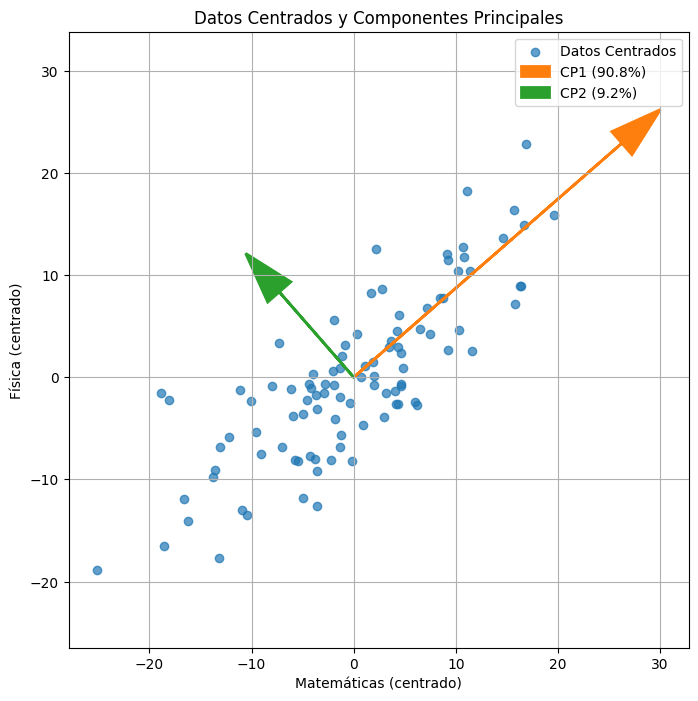

In [10]:
# 3. Visualizar los Componentes
plt.figure(figsize=(8, 8))
plt.scatter(X_centrado[:, 0], X_centrado[:, 1], alpha=0.7, label='Datos Centrados')

# Graficamos los vectores de los componentes
for i, (comp, var) in enumerate(zip(pca_simple.components_, pca_simple.explained_variance_)):
    # Multiplicamos el componente (vector unitario) por la raíz de la varianza (desviación estándar)
    # para darle una longitud proporcional a la información que captura. Usamos un factor (3) para que sea más visible.
    comp = comp * np.sqrt(var) * 3
    plt.arrow(0, 0, comp[0], comp[1],
              head_width=3, head_length=5, fc=f'C{i+1}', ec=f'C{i+1}', linewidth=2,
              label=f'CP{i+1} ({pca_simple.explained_variance_ratio_[i]*100:.1f}%)')

plt.title('Datos Centrados y Componentes Principales')
plt.xlabel('Matemáticas (centrado)')
plt.ylabel('Física (centrado)')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

**Interpretación del gráfico y los resultados:**

- Los **puntos azules** son nuestros datos originales, pero centrados en el origen (0,0).
- El **vector naranja (CP1)** apunta exactamente en la dirección donde los datos están más dispersos (la dirección de la diagonal). PCA nos dice que este componente explica ¡el **90.8%** de la varianza total!
- El **vector verde (CP2)** es perpendicular al CP1 y apunta en la dirección de la varianza restante (solo el **9.2%**).

**La Reducción:**

Como el CP1 captura casi toda la información, podemos **descartar el CP2**.

Hemos **reducido la dimensionalidad de 2D a 1D**. En lugar de tener dos puntajes (`Puntaje_Matemáticas`, `Puntaje_Física`), ahora podemos representar a cada estudiante con un solo valor: su proyección sobre el eje CP1. Este nuevo valor podría interpretarse como un **"Índice General de Aptitud Científica"**.

## Ejemplo de PCA para Visualización y Segmentación

Ahora veremos un ejemplo clásico. El dataset de "Vinos" contiene los resultados de un análisis químico de **13 constituyentes** (alcohol, acidez, magnesio, etc.) para **3 tipos diferentes de vino** cultivados en la misma región de Italia.

**El Problema:** ¿Podemos visualizar si estos 3 tipos de vino son químicamente distintos? Graficar en 13 dimensiones es imposible.

**El Objetivo:** Usaremos PCA para reducir estas 13 dimensiones a solo 2 y así poder graficar los 3 tipos de vino en un plano 2D para ver si se separan y se diferencian.

### Importar librerías

In [11]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler

### Mejorar visualización de dataframes y gráficos

In [12]:
# Que muestre todas las columnas
pd.options.display.max_columns = None
# En los dataframes, mostrar los float con dos decimales
pd.options.display.float_format = '{:,.2f}'.format

# Configuraciones para una mejor visualización
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [13]:
# Cargar el dataset de vinos desde sklearn
wine_data = load_wine()
X_wine = pd.DataFrame(wine_data.data, columns=wine_data.feature_names)
y_wine = wine_data.target # Esta es nuestra variable objetivo (tipo de vino 0, 1 o 2)

In [14]:
X_wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.60,127.00,2.80,3.06,0.28,2.29,5.64,1.04,3.92,"1,065.00"
1,13.20,1.78,2.14,11.20,100.00,2.65,2.76,0.26,1.28,4.38,1.05,3.40,"1,050.00"
2,13.16,2.36,2.67,18.60,101.00,2.80,3.24,0.30,2.81,5.68,1.03,3.17,"1,185.00"
3,14.37,1.95,2.50,16.80,113.00,3.85,3.49,0.24,2.18,7.80,0.86,3.45,"1,480.00"
4,13.24,2.59,2.87,21.00,118.00,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.00


In [15]:
y_wine

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [16]:
print("dimensiones de las características: ", X_wine.shape)
print("\nNombre de las 13 variables químicas:")
print(X_wine.columns)

dimensiones de las características:  (178, 13)

Nombre de las 13 variables químicas:
Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline'],
      dtype='object')


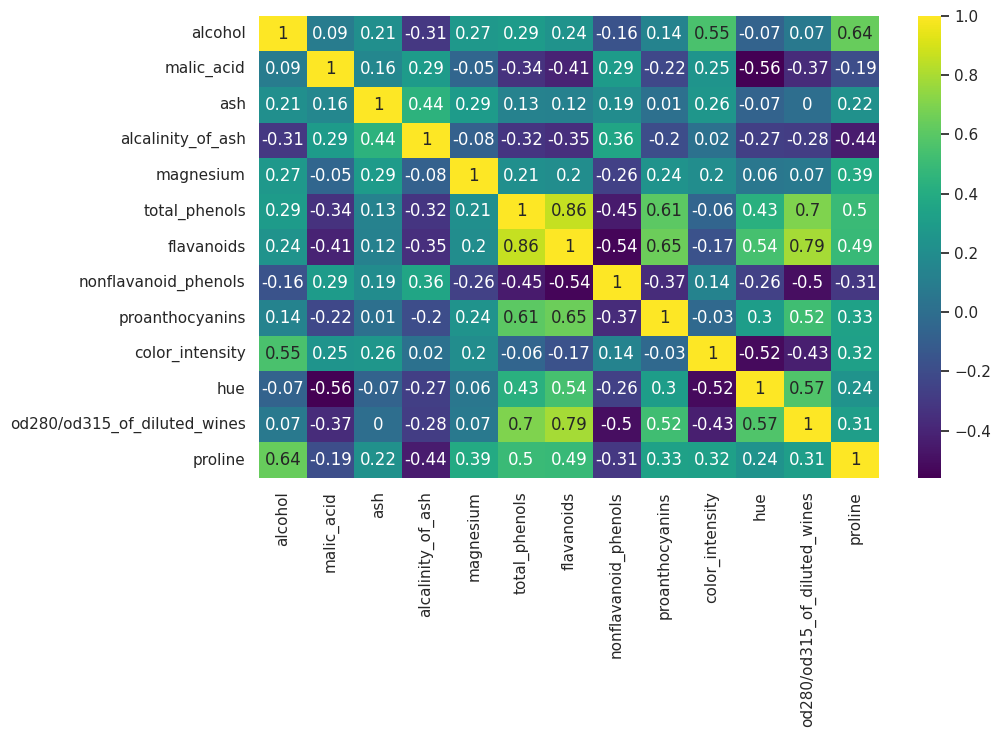

In [17]:
corr = X_wine.corr().round(2)
sns.heatmap(corr, annot=True, cmap='viridis')
plt.show()

### Estandarización de los Datos

Como vimos, este paso es **crítico**. Las 13 variables químicas tienen escalas totalmente diferentes, por lo que debemos estandarizarlas.

In [18]:
scaler_wine = StandardScaler()
X_wine_scaled = scaler_wine.fit_transform(X_wine)

### Aplicación de PCA y Selección de Componentes

Vamos a aplicar PCA y ver cuánta varianza explican los componentes.

In [19]:
pca_wine = PCA()
pca_wine.fit(X_wine_scaled)

PCA()

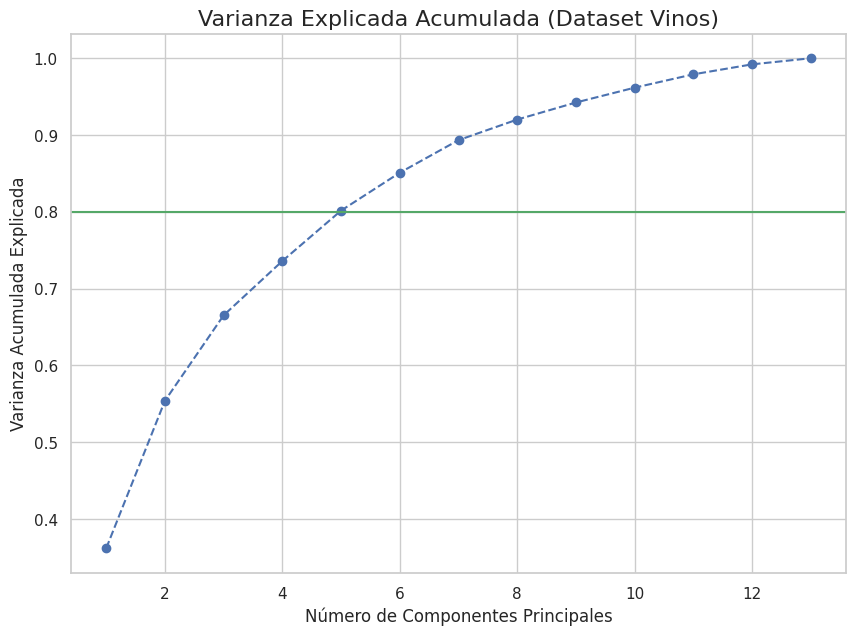

In [20]:
# Graficamos la varianza explicada acumulada
varianza_acumulada_wine = np.cumsum(pca_wine.explained_variance_ratio_)

plt.figure(figsize=(10, 7))
plt.plot(range(1, len(varianza_acumulada_wine) + 1), varianza_acumulada_wine, marker='o', linestyle='--')
plt.title('Varianza Explicada Acumulada (Dataset Vinos)', fontsize=16)
plt.xlabel('Número de Componentes Principales', fontsize=12)
plt.ylabel('Varianza Acumulada Explicada', fontsize=12)
plt.axhline(y=0.8, color='g', linestyle='-', label='80% de Varianza')
plt.show()

**Interpretación del Gráfico:**

Los dos primeros componentes (CP1 y CP2) explican **más del 55%** de la varianza total. Si bien no es un umbral altísimo como 90%, para un objetivo de **visualización** en 2D, está bien. Nos quedaremos solo con 2 componentes.

Vamos a re-aplicar PCA pidiendo solo 2 componentes.

In [21]:
pca_wine_2 = PCA(n_components=2)
X_wine_pca = pca_wine_2.fit_transform(X_wine_scaled)

print("Dimensiones del dataset original:", X_wine_scaled.shape)
print("Dimensiones del dataset reducido:", X_wine_pca.shape)

Dimensiones del dataset original: (178, 13)
Dimensiones del dataset reducido: (178, 2)


In [22]:
# Varianza explicada
pca_wine_2.explained_variance_ratio_

array([0.36198848, 0.1920749 ])

In [23]:
# Varianza explicada acumulada
pca_wine_2.explained_variance_ratio_.cumsum()

array([0.36198848, 0.55406338])

**En el gráfico de varianza acumulada, ¿cómo decido el número exacto de componentes?**

No hay una regla dura y fija, es más un criterio de negocio o de investigación. La elección implica un trade-off entre la simplicidad del modelo y la cantidad de información que retenemos. Las guías más comunes son:

- **El Método del Codo:** Buscas en el gráfico el punto donde añadir un nuevo componente ya no aporta un gran aumento en la varianza explicada. Es el "codo" de la curva.

- **Umbral de Varianza Acumulada:** La regla más usada en la práctica. Se decide un umbral, por ejemplo, 'quiero explicar al menos el 90% de la varianza'. Y se eligen los componentes necesarios para alcanzarlo. Para análisis exploratorios rápidos, un 80% puede ser suficiente. Para modelos que irán a producción, se suele exigir 95% o incluso 99%.

- **Interpretabilidad:** A veces, eliges un número de componentes que, aunque no lleguen a un umbral alto, son muy fáciles de interpretar económicamente. Por ejemplo, si con 3 componentes explicas el 75% de la varianza y puedes llamarlos 'Crecimiento', 'Estabilidad' y 'Capital Humano', esa simplicidad puede ser más valiosa que tener 8 componentes que expliquen el 95% pero sean ininteligibles."

### 1.4 Visualización de la Segmentación de Vinos

Ahora, vamos a graficar cada vino usando sus nuevos dos ejes (CP1 y CP2) y los colorearemos por su tipo de vino real (la variable `y_wine`).

In [24]:
# Guardamos los resultados en un nuevo dataframe
df_wine_pca = pd.DataFrame(X_wine_pca, columns=['CP1', 'CP2'])
df_wine_pca['Tipo_Vino'] = y_wine
df_wine_pca.head()

,CP1,CP2,Tipo_Vino
0,3.32,1.44,0
1,2.21,-0.33,0
2,2.52,1.03,0
3,3.76,2.76,0
4,1.01,0.87,0


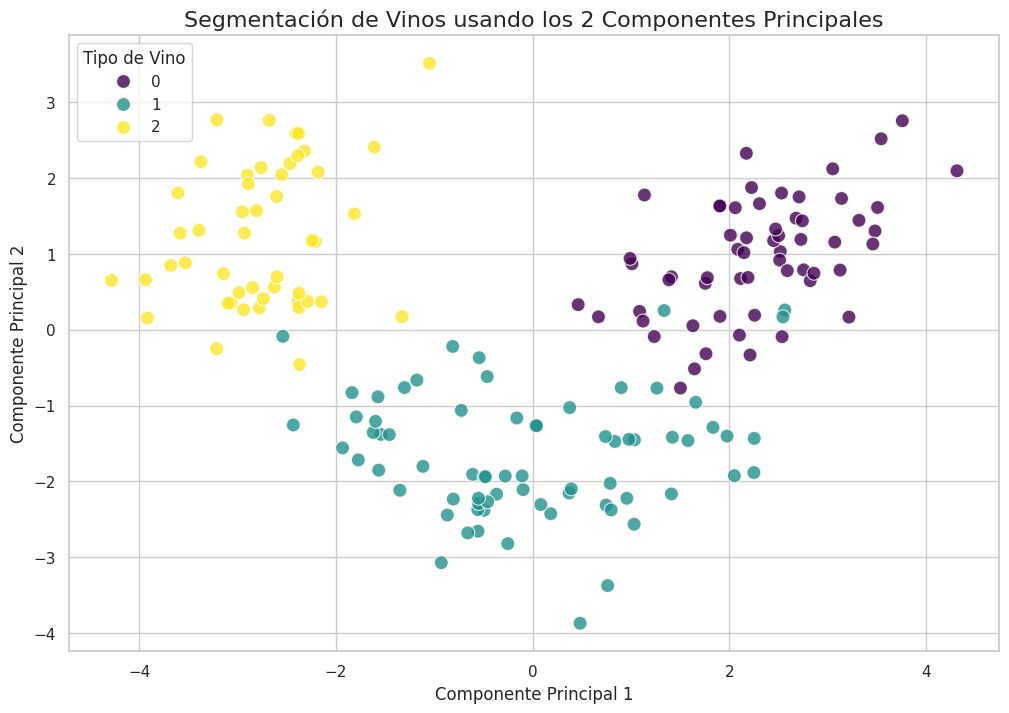

In [25]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='CP1', y='CP2', data=df_wine_pca, hue='Tipo_Vino', palette='viridis', s=100, alpha=0.8)
plt.title('Segmentación de Vinos usando los 2 Componentes Principales', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.legend(title='Tipo de Vino')
plt.show()

**Conclusión de la Visualización:**

PCA logró tomar las 13 variables químicas y proyectarlas en 2 dimensiones de tal forma que los tres tipos de vino (0, 1 y 2) **quedan casi perfectamente separados**.

Esto nos demuestra que la composición química de los vinos es, en efecto, distinta, y que PCA fue capaz de encontrar los "ejes" (componentes) que mejor demuestran esta separación. Ahora, cualquier modelo de clasificación que use CP1 y CP2 será extremadamente efectivo.

### Interpretación de los Loadings (¿Qué significan CP1 y CP2?)

Ya vimos que los componentes separan los vinos, pero... ¿qué son? ¿Qué característica química están midiendo? Para esto, analizamos los **loadings**.

In [26]:
df_wine_loadings = pd.DataFrame(pca_wine_2.components_,
                                columns=wine_data.feature_names,
                                index=['CP1', 'CP2'])
df_wine_loadings

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
CP1,0.14,-0.25,-0.00,-0.24,0.14,0.39,0.42,-0.30,0.31,-0.09,0.30,0.38,0.29
CP2,0.48,0.22,0.32,-0.01,0.30,0.07,-0.00,0.03,0.04,0.53,-0.28,-0.16,0.36


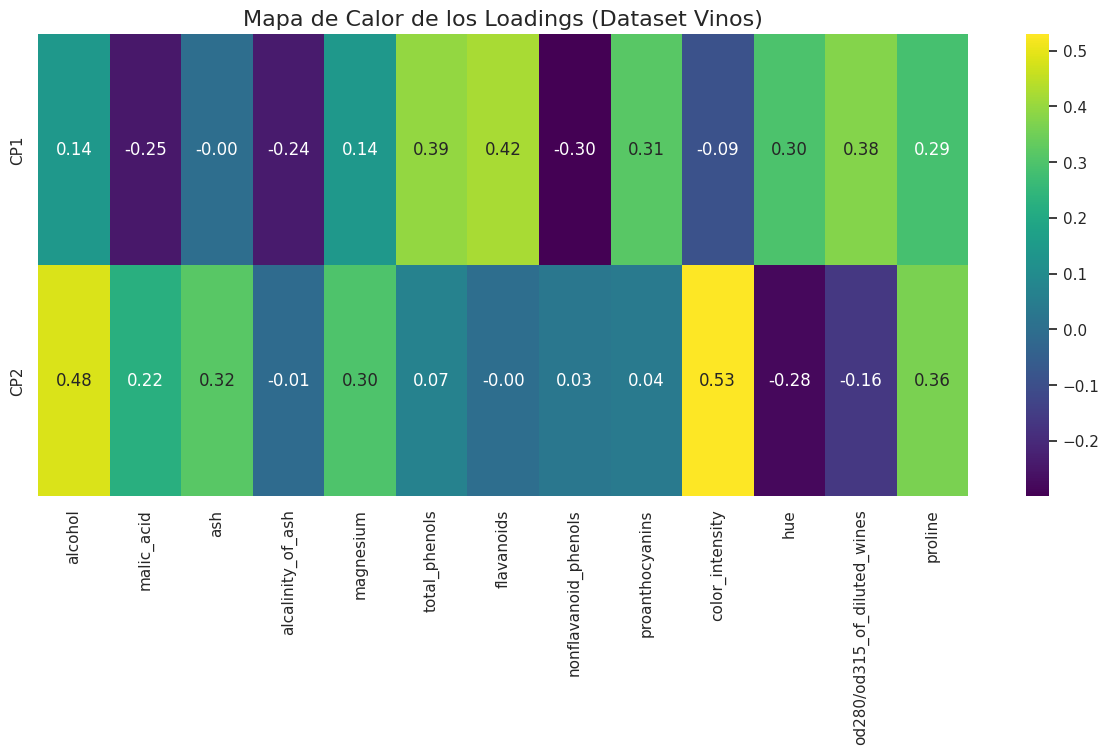

In [27]:
plt.figure(figsize=(15, 6))
sns.heatmap(df_wine_loadings, annot=True, cmap='viridis', fmt='.2f')
plt.title('Mapa de Calor de los Loadings (Dataset Vinos)', fontsize=16)
plt.show()

**Interpretación 🍇:**

Miremos qué variables tienen los pesos (loadings) más altos en cada componente:

* **Componente Principal 1 (CP1):**
    * Tiene cargas **altas y positivas** en `flavanoids` (0.42), `total_phenols` (0.39) y `od280/od315_of_diluted_wines` (0.38). Estos son **antioxidantes** que vienen de la cáscara de la uva y dan estructura y color al vino.
    * Tiene cargas **negativas** en `nonflavanoid_phenols` (-0.3), `malic_acid` (-0.25) y `alcalinity_of_ash` (-0.24).
    * **Interpretación:** El CP1 parece ser un **"Índice de Estructura y Madurez"**. Un valor alto en CP1 (hacia la derecha en el gráfico) representa vinos con muchos fenoles y flavonoides (típico de vinos tintos robustos). Vemos que los vinos tipo 0 están a la derecha, y los tipo 1 y 2 a la izquierda.

* **Componente Principal 2 (CP2):**
    * Tiene cargas **altas y positivas** en `color_intensity` (0.53), `alcohol` (0.48) y `proline` (0.36).
    * Tiene cargas **altas y negativas** en `hue` (-0.28) y `od280/od315_of_diluted_wines` (-0.16).
    * **Interpretación:** El CP2 parece ser un **"Índice de Graduación Alcohólica y Color"**. Un valor alto en CP2 (hacia arriba en el gráfico) representa vinos con más alcohol y color. Vemos que este eje es el que mejor separa los vinos tipo 1 (abajo) de los vinos tipo 2 (arriba).

**Conclusión:** Hemos reducido 13 variables químicas a 2 índices interpretables que segmentan perfectamente el mercado.

### Aplicación: Clustering con K-Means sobre Componentes Principales

Hemos visto que PCA ayuda a visualizar la separación natural de los vinos. ¿Podría un algoritmo de clustering como K-Means **descubrir estos grupos por sí mismo**, usando solo los componentes principales?

Como vimos con el dataset de casas, K-Means funciona mucho mejor en espacios de baja dimensionalidad. Apliquémoslo a nuestros 2 componentes del vino.

In [28]:
from sklearn.cluster import KMeans

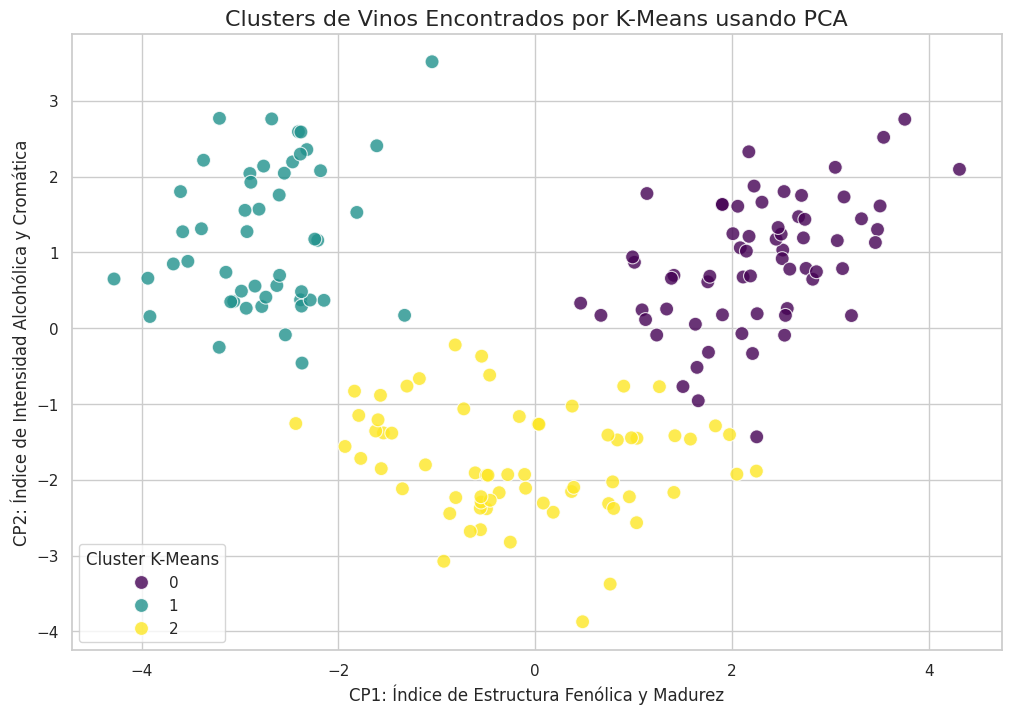

In [29]:
# Instanciamos KMeans pidiendo 3 clusters (sabemos que hay 3 tipos de vino)
kmeans_wine = KMeans(n_clusters=3, random_state=42, n_init=10)

# Ajustamos y predecimos sobre los datos PCA (X_wine_pca tiene CP1 y CP2)
df_wine_pca['Cluster_KMeans'] = kmeans_wine.fit_predict(X_wine_pca)

# Visualizamos los clusters encontrados por K-Means
plt.figure(figsize=(12, 8))
sns.scatterplot(x='CP1', y='CP2', data=df_wine_pca, hue='Cluster_KMeans', palette='viridis', s=100, alpha=0.8)
plt.title('Clusters de Vinos Encontrados por K-Means usando PCA', fontsize=16)
plt.xlabel('CP1: Índice de Estructura Fenólica y Madurez', fontsize=12)
plt.ylabel('CP2: Índice de Intensidad Alcohólica y Cromática', fontsize=12)
plt.legend(title='Cluster K-Means')
plt.show()

**Comparación y Conclusión:**

Comparen este gráfico con el anterior coloreado por `Tipo_Vino`. K-Means, utilizando solo las coordenadas CP1 y CP2, ha sido capaz de **recrear casi perfectamente la separación original** de los tres tipos de vino. Los colores de los clusters pueden no coincidir exactamente con los números originales (K-Means asigna 0, 1, 2 arbitrariamente), pero la **agrupación es casi la misma**.

Esto demuestra cómo PCA, al reducir la dimensionalidad y el ruido, crea una representación de los datos donde los grupos subyacentes se vuelven mucho más evidentes y fáciles de detectar para algoritmos como K-Means. Es un excelente ejemplo de **PCA como preprocesamiento para clustering**.

## Ventajas de utilizar PCA

- **Interpretabilidad:** Es imposible explicarle a un gerente o a un ministro qué significa el coeficiente de 50 variables diferentes. Pero es muy poderoso decirle: 'Hemos creado un Índice de Dinamismo Económico (nuestro CP1), y por cada punto que un país mejora en este índice, la inversión extranjera aumenta en X%'. PCA nos ayuda a contar una historia más clara.

- **Reducir la Multicolinealidad:** En econometría, sabemos que la multicolinealidad (alta correlación entre variables predictoras) infla los errores estándar de nuestros coeficientes y hace que el modelo sea inestable. Como los componentes principales son, por construcción, no correlacionados entre sí, eliminamos este problema de raíz.

- **Eficiencia Computacional:** Entrenar un modelo con 500 variables puede ser lento y costoso. Si PCA nos permite obtener un 95% de la misma información con solo 30 componentes, el proceso es mucho más rápido y eficiente. Es como optimizar los recursos de cómputo."



## Conclusiones

La **reducción de dimensionalidad con PCA** es una herramienta poderosa para el economista y el científico de datos, ya que nos permite:

1.  **Combatir la Maldición de la Dimensionalidad:** Simplificamos modelos complejos, reducimos el riesgo de overfitting y mejoramos la eficiencia computacional.
2.  **Crear Variables Sintéticas Interpretables:** Pasamos de un conjunto de variables correlacionadas a un nuevo conjunto de "índices" (los componentes) que resumen la información y tienen un significado económico o de negocio.
3.  **Mejorar la Visualización:** Nos permite explorar la estructura oculta de nuestros datos en 2D o 3D, revelando patrones que serían invisibles de otra manera (Ej. Vinos).
4.  **Actuar como un paso de Ingeniería de Características:**
    - **Para Clustering:** Permite que algoritmos como K-Means funcionen correctamente al reducir el ruido y el espacio dimensional.
    - **Para Regresión Lineal y, en general, Aprendizaje Supervisado:** Resuelve el problema de la multicolinealidad. Se tiene un modelo mucho más parsimonioso (menos variables). Puede, incluso, mejorar la precisión del modelo al filtrar el ruido.